In [1]:
import math
import cv2
import os
from sklearn.svm import SVC
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Model, Sequential
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping
from keras.layers import Softmax, Conv2D, Conv2DTranspose, MaxPooling2D, ReLU, Dense, Normalization, Dropout, Lambda, BatchNormalization, RandomFlip, RandomRotation
import random
from time import time
random.seed(1234)

In [2]:
# Establecemos una semilla
random.seed(1234)

# Creamos una función que lea todas las imágenes de un directorio
# concreto.
def load_images(directorio, color=0):
    x_imagenes = []
    y_imagenes = []
    for filename in os.listdir("{}/images".format(directorio)):
        filename_mask = filename[:-4]
        filename_mask = "{}_mask.png".format(filename_mask)

        nombre_x = "{}/images/{}".format(directorio, filename)
        nombre_mascara = "{}/mask/{}".format(directorio, filename_mask)
        img = cv2.imread(nombre_x,color)
        mascara = cv2.imread(nombre_mascara,0)
        if img is not None:
            x_imagenes.append(img)
            y_imagenes.append(mascara)
    return x_imagenes, y_imagenes

In [3]:

# Leemos las imágenes de entrenamiento
X_train, y_train = load_images("data/segmentation/train",1)
# Leemos las imágenes de test
X_test, y_test = load_images("data/segmentation/test",1)


In [4]:
def reescalar(conjunto_imagenes, nuevo_tam):
    imagenes_reescaladas = []
    
    for img in conjunto_imagenes:
        imagenes_reescaladas.append(cv2.resize(img, nuevo_tam))
    
    return np.array(imagenes_reescaladas)

In [5]:
NUEVO_TAM = (502, 502)


X_train_val = reescalar(X_train, NUEVO_TAM)
y_train_val_inicial = reescalar(y_train, NUEVO_TAM)
X_test = reescalar(X_test, NUEVO_TAM)
y_test_inicial = reescalar(y_test, NUEVO_TAM)


print(X_train_val[0].shape)

(502, 502, 3)


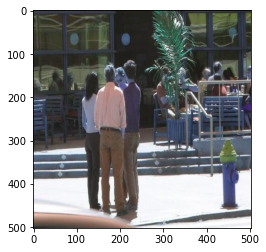

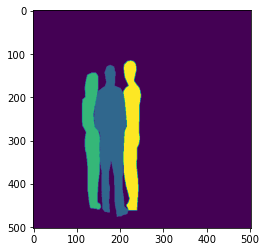

In [6]:
plt.figure()
plt.imshow(X_train_val[0])
plt.show()

plt.figure()
plt.imshow(y_train_val_inicial[0])
plt.show()

In [20]:
y_train_val = []
y_test = []

for imagen in y_train_val_inicial:
    resultado = np.where(imagen == 0, 0, 255).astype(np.uint8)
    y_train_val.append(cv2.cvtColor(resultado, cv2.COLOR_GRAY2BGR))


for imagen in y_test_inicial:
    resultado = np.where(imagen == 0, 0, 255).astype(np.uint8)
    y_test.append(cv2.cvtColor(resultado, cv2.COLOR_GRAY2BGR))
    
y_train_val = np.array(y_train_val)
y_test = np.array(y_test)


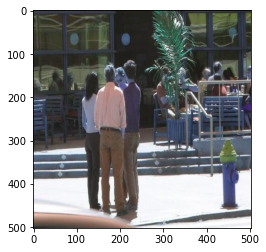

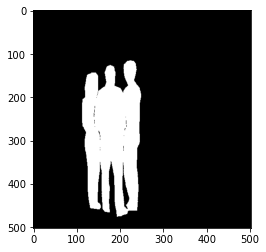

In [21]:
plt.figure()
plt.imshow(X_train_val[0])
plt.show()

plt.figure()
plt.imshow(y_train_val[0])
plt.show()

In [22]:
ntrain = round(0.8*len(y_train_val))
nval = len(X_train_val)-ntrain

idx = np.random.permutation(np.arange(len(y_train_val)))
X_train = X_train_val[idx[0:ntrain],:]
y_train = y_train_val[idx[0:ntrain]]
X_val = X_train_val[idx[ntrain+1:len(y_train_val)],:]
y_val = y_train_val[idx[ntrain+1:len(y_train_val)]]


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)



2022-06-08 10:53:16.658950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 10:53:16.659936: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
## Función que muestra la evolución de las accuracy de train y validación
## durante el entrenamiento.
def mostrar_evolucion(hist):

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['categorical_crossentropy']
    val_acc = hist.history['val_binary_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()

modelo_base = Sequential([
    Normalization(input_shape = (NUEVO_TAM[0], NUEVO_TAM[1], 3)),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    # pasamos a decodificar
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2D(3, 1, strides = (1, 1), padding = "valid", activation = "softmax")
])

modelo_base.summary()

modelo_base.compile(
    optimizer = Adam(),
    loss = "categorical_crossentropy"
)

# Entrenamos el modelo usando callbacks para parar de entrenar
# si la validación se aleja demasiado del entrenamiento
callback = EarlyStopping(patience=3,restore_best_weights=True)
start = time()
history = modelo_base.fit(train_dataset,
                epochs = 40,
                validation_data = validation_dataset,
                callbacks = callback)
first_training_time = time()-start
mostrar_evolucion(history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 502, 502, 3)      7         
 ion)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 502, 502, 64)      1792      
                                                                 
 re_lu_3 (ReLU)              (None, 502, 502, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 251, 251, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 251, 251, 64)      36928     
                                                                 
 re_lu_4 (ReLU)              (None, 251, 251, 64)     

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 508, in dispatch_queue
      await self.process_one()
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 497, in process_one
      await dispatch(*args)
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 404, in dispatch_shell
      await result
    File "/usr/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 728, in execute_request
      reply_content = await reply_content
    File "/usr/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23729/1437667773.py", line 47, in <cell line: 47>
      history = modelo_base.fit(train_dataset,
    File "/usr/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/usr/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/lib/python3.10/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/usr/lib/python3.10/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/lib/python3.10/site-packages/keras/losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/usr/lib/python3.10/site-packages/keras/backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [8064128,3] and labels shape [24192384]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_2580]

In [ ]:
predicciones = modelo_base.predict(test_dataset)

In [ ]:
plt.figure()
plt.imshow(predicciones[0], "gray")
plt.show()

plt.figure()
plt.imshow(y_test[0])
plt.show()


In [ ]:

PATH_PREDICCIONES = "predicciones_test_segmentacion"

if not os.path.isdir(PATH_PREDICCIONES):
    os.mkdir(PATH_PREDICCIONES)

i = 0
for prediccion in predicciones:
    cv2.imwrite("{}/img_test_{}.png".format(PATH_PREDICCIONES, i), prediccion)
    i += 1
